# Preamble

In [1]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import petpal.kinetic_modeling.tcms_as_convolutions as pet_tcm
import petpal.kinetic_modeling.reference_tissue_models as pet_rtms
from petpal.utils.image_io import safe_load_tac
from petpal.utils.testing_utils import generate_random_parameter_samples, add_gaussian_noise_to_tac_based_on_max, scatter_with_regression_figure, bland_atlman_figure, ratio_bland_atlman_figure
from importlib import reload

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] = 'StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.dpi'] = 72


text_box = dict(facecolor='lightblue', edgecolor='black', lw=2, alpha=0.2)

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Convenience Functions

### Results Formatting

In [2]:
def calc_diff(true_value, fit_value):
    """
    Calculate the difference and the percentage difference between the real and the new answer.
    
    Args:
        real_answer (float): The real or original answer.
        new_answer (float): The new answer to be compared.
    
    Returns:
        tuple: The new answer, the difference, and the percentage difference.
    """
    diff = fit_value - true_value
    per_d = diff / true_value * 100.
    
    return fit_value, diff, per_d


def print_arrs(pre_str: str, *args):
    """
    Print arrays with a prefix string in a well-formatted manner.

    Args:
        pre_str (str): The prefix string.
        *args: Variable length argument list representing the arrays to be printed.
    """
    print(f"{pre_str + ':':<8}", end=' ')
    for an_arr in args:
        str_arr = [f"{a_num:<5.2f}" for a_num in an_arr]
        print(f"({', '.join(str_arr)})", end='; ')
    print()

### Fitting Large Numbers Of Samples

In [3]:
def calculate_bounded_rtm_fits_from_multiple_parameter_samples(ref_tac_times,
                                                               ref_tac_vals,
                                                               param_samples,
                                                               model_func,
                                                               fit_func,
                                                               start,
                                                               hi,
                                                               lo,
                                                               noise_scale=0.01):
    num_samples, num_params = param_samples.shape
    assert len(param_samples.shape) == 2, "Only implemented for 2-d samples"
    
    fit_vals = np.zeros((num_samples, num_params))
    fit_covs = np.zeros((num_samples, num_params, num_params))
    for tID, t_param in enumerate(param_samples):
        rtm_tac_vals = model_func(ref_tac_times, ref_tac_vals, *t_param)
        if np.min(rtm_tac_vals) < 0.0:
            p_opt = np.nan * np.ones(num_params, float)
            p_cor = np.nan * np.ones((num_params, num_params), float)
        else:
            noisy_tgt_tac_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, noise_scale)
            try:
                bounds = [(start, lo, hi)] * num_params
                p_opt, p_cor = fit_func(ref_tac_times, noisy_tgt_tac_vals, ref_tac_vals, *bounds)
            except RuntimeError:
                p_opt = np.nan * np.ones(num_params, float)
                p_cor = np.nan * np.ones((num_params, num_params), float)
        #                 print("Could not coverge.")
        fit_vals[tID] = p_opt[:] + 0.0
        fit_covs[tID] = p_cor[:] + 0.0
    return fit_vals, fit_covs

In [4]:
def calculate_rtm_fits_from_multiple_parameter_samples(ref_tac_times,
                                                       ref_tac_vals,
                                                       param_samples,
                                                       model_func,
                                                       fit_func,
                                                       noise_scale=0.01):
    num_samples, num_params = param_samples.shape
    assert len(param_samples.shape) == 2, "Only implemented for 2-d samples"
    
    fit_vals = np.zeros((num_samples, num_params))
    fit_covs = np.zeros((num_samples, num_params, num_params))
    for tID, t_param in enumerate(param_samples):
        rtm_tac_vals = model_func(ref_tac_times, ref_tac_vals, *t_param)
        if np.min(rtm_tac_vals) < 0.0:
            p_opt = np.nan * np.ones(num_params, float)
            p_cor = np.nan * np.ones((num_params, num_params), float)
        else:
            noisy_tgt_tac_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, noise_scale)
            try:
                p_opt, p_cor = fit_func(ref_tac_times, noisy_tgt_tac_vals, ref_tac_vals)
            except RuntimeError:
                p_opt = np.nan * np.ones(num_params, float)
                p_cor = np.nan * np.ones((num_params, num_params), float)
        #                 print("Could not coverge.")
        fit_vals[tID] = p_opt[:] + 0.0
        fit_covs[tID] = p_cor[:] + 0.0
    return fit_vals, fit_covs

# Simplified Reference Tissue Model (SRTM)

The analytical solution for the SRTM describes the tissue TAC, $C(t)$, as a function of a reference TAC, $C_\mathrm{R}(t)$, is:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - \frac{R_{1}k_{2}}{1+\mathrm{BP_\mathrm{ND}}} \right) C_\mathrm{R}(t)\otimes \exp\left[-\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}} t\right].
$$
By defining $\alpha\equiv\frac{k_{2}}{1+\mathrm{BP_\mathrm{ND}}}$, we can rewrite the equation as:
$$
C(t) = R_{1} C_\mathrm{R}(t) + \left( k_{2} - R_{1}\alpha\right) C_\mathrm{R}(t)\otimes \exp\left[-\alpha \cdot t\right].
$$

## Loading An Input Function

In [5]:
input_tac_times, input_tac_vals = safe_load_tac("../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt")
# input_tac_times *= 60.0 #To change time to seconds

## Generating An Example Reference Region
We use a 1TCM with $K_1=1.0$ and $k_2=0.2$.

In [6]:
ref_tac_times, ref_tac_vals = pet_tcm.generate_tac_1tcm_c1_from_tac(tac_times=input_tac_times, tac_vals=input_tac_vals,
                                                                    k1=1.0, k2=0.2)

### Example SRTM TAC
We use $R_1=1.0$, $k_2=0.25$ and $BP=3.0$.

In [7]:
srtm_tac_vals = pet_rtms.calc_srtm_tac(tac_times_in_minutes=ref_tac_times, ref_tac_vals=ref_tac_vals, r1=1.0, k2=0.25, bp=3.0)

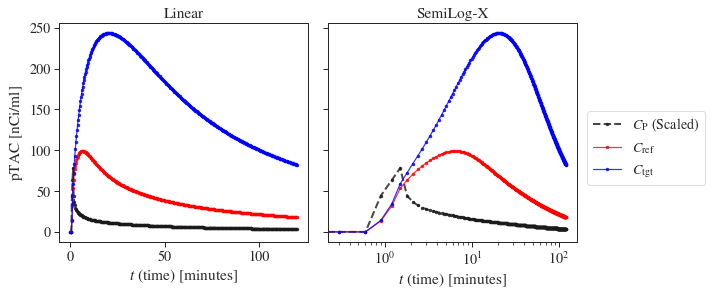

In [8]:
myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], sharey=True, dpi=72)
for anAx in myAx.flatten():
    anAx.plot(input_tac_times, input_tac_vals, '.--', alpha=0.8, color='k', label=r'$C_\mathrm{P}$ (Scaled)', lw=2)
    anAx.plot(ref_tac_times, ref_tac_vals, '.-', alpha=0.8, color='red', label=r'$C_\mathrm{ref}$')
    anAx.plot(ref_tac_times, srtm_tac_vals, '.-', alpha=0.8, color='blue', label=r'$C_\mathrm{tgt}$')
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Simple Visual Inspection Of Fits

In [10]:
srtm_test_params = generate_random_parameter_samples(5, 3, hi=3.0, lo=0.001)
srtm_test_params

array([[1.09877979, 2.71715728, 1.7391151 ],
       [2.32913159, 2.72957785, 1.22105204],
       [2.43192022, 0.57623021, 2.60022039],
       [2.5260903 , 2.66547516, 0.51520113],
       [2.64495487, 0.6931381 , 0.00934889]])

### Plotting Data And Fits Together

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (1.10 , 2.72 , 1.74 ); 
pOpt:    (1.09 , 2.76 , 1.74 ); (-0.01, 0.05 , 0.00 ); (-0.57, 1.76 , 0.01 ); 


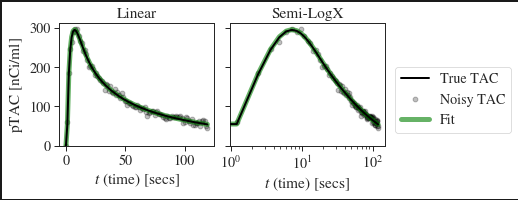

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (2.33 , 2.73 , 1.22 ); 
pOpt:    (2.50 , 4.35 , 1.27 ); (0.17 , 1.62 , 0.04 ); (7.44 , 59.34, 3.68 ); 


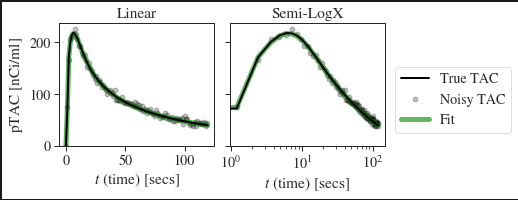

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (2.43 , 0.58 , 2.60 ); 
pOpt:    (2.44 , 0.58 , 2.60 ); (0.01 , 0.00 , -0.00); (0.38 , 0.30 , -0.04); 


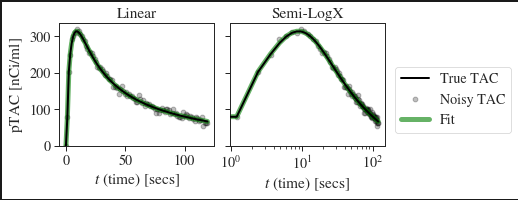

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (2.53 , 2.67 , 0.52 ); 
pOpt:    (2.40 , 2.40 , 0.47 ); (-0.13, -0.27, -0.05); (-5.14, -10.08, -8.97); 


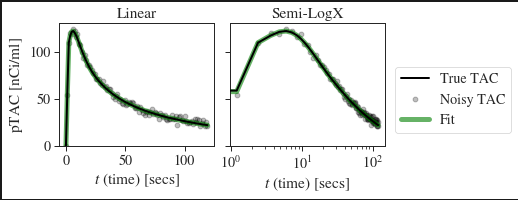

--------------------------------------------------------------------------------
Value                         ;Diff                  ;%Diff                           
Actual:  (2.64 , 0.69 , 0.01 ); 
pOpt:    (2.67 , 0.71 , 0.01 ); (0.02 , 0.02 , 0.00 ); (0.91 , 3.02 , 32.03); 


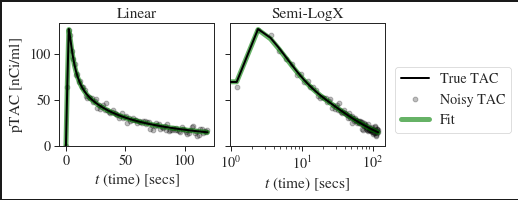

In [11]:
stride = 4
model_func = pet_rtms.calc_srtm_tac
for tID, t_params in enumerate(srtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, ref_tac_vals, *t_params)
    if np.min(rtm_tac_vals) < 0:
        continue
    print('-' * 80)
    print(f"{'Value':<30};{'Diff':<22};{'%Diff':<32}")
    
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.02)
    
    pOpt, pCor = pet_rtms.fit_srtm_to_tac_with_bounds(tac_times=ref_tac_times,
                                                      tgt_tac_vals=noisy_tgt_vals, 
                                                      ref_tac_vals=ref_tac_vals, r1_bounds=(1.0, 0.0001, 10.0),
                                                      k2_bounds=(1.0, 0.0001, 10.0), bp_bounds=(1.0, 0.0001, 10.0))
    print_arrs("Actual", t_params)
    print_arrs("pOpt", *calc_diff(t_params, pOpt))
    
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8 / 1.5, 4 / 1.5], sharey=True, linewidth=3.0,
                               edgecolor='k')
    for anAx in myAx.flatten():
        anAx.plot(ref_tac_times[::stride], rtm_tac_vals[::stride], '-', alpha=1.0, color='black', label=r'True TAC',
                  lw=2.0, zorder=4)
        anAx.plot(ref_tac_times[::stride], noisy_tgt_vals[::stride], 'o', alpha=0.25, color='black', label=r'Noisy TAC')
        yAr = model_func(ref_tac_times, ref_tac_vals, *pOpt)
        anAx.plot(ref_tac_times[::stride], yAr[::stride], '-', alpha=0.6, color='green', lw=5, label='Fit')
    
    leg_hands, leg_labs = list(myAx[0].get_legend_handles_labels())
    
    myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear', ylim=(-0.25, None), xlabel='$t$ (time) [secs]')
    myAx[1].set(xscale='log', ylim=(-0.0001, None), title='Semi-LogX', xlabel='$t$ (time) [secs]')
    
    myFig.legend(leg_hands, leg_labs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.show()


## Generating A Simple Scatter Plot Of Fits vs. Real Values From Many Random Values

### Unbounded Fits

#### Generating Random Samples

In [12]:
num_samples = 5000

srtm_test_params_large = generate_random_parameter_samples(num_samples=num_samples, num_params=3, hi=3.0, lo=0.001)
srtm_fits_unbounded, srtm_fit_covs_unbounded = calculate_rtm_fits_from_multiple_parameter_samples(
    ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=srtm_test_params_large,
    model_func=pet_rtms.calc_srtm_tac, fit_func=pet_rtms.fit_srtm_to_tac, noise_scale=0.01)

#### Scatter Plot

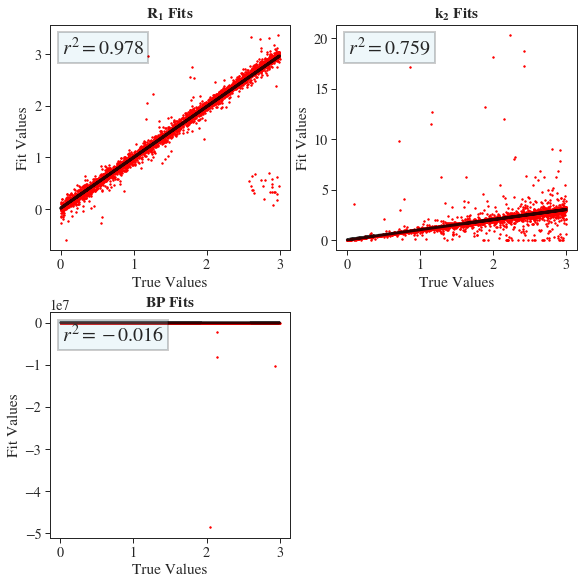

In [13]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
scatter_with_regression_figure(axes=myAx,
                               fit_values=srtm_fits_unbounded,
                               true_values=srtm_test_params_large,
                               ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
# myFig.suptitle("Unbounded Fits For SRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

#### Bland-Altman Plot

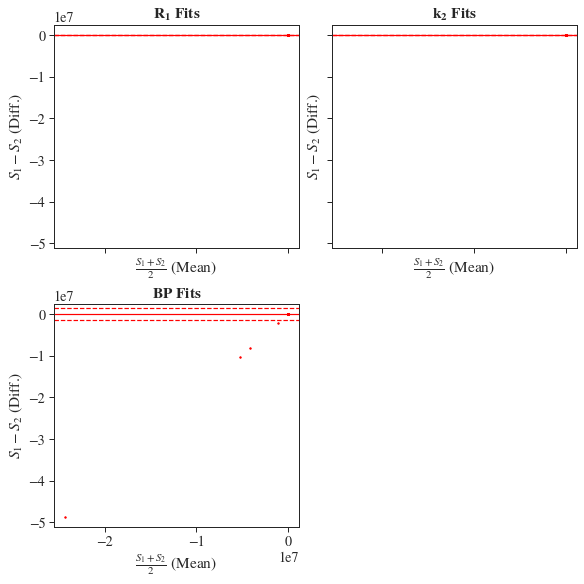

In [14]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], 
                           constrained_layout=True, sharex=True, sharey=True)
bland_atlman_figure(axes=myAx,
                    fit_values=srtm_fits_unbounded,
                    true_values=srtm_test_params_large,
                    ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

#### Ratio Bland Altman Plot

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/utils/testing_utils.py:270: RuntimeWarning:

invalid value encountered in log

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/utils/testing_utils.py:271: RuntimeWarning:

invalid value encountered in log



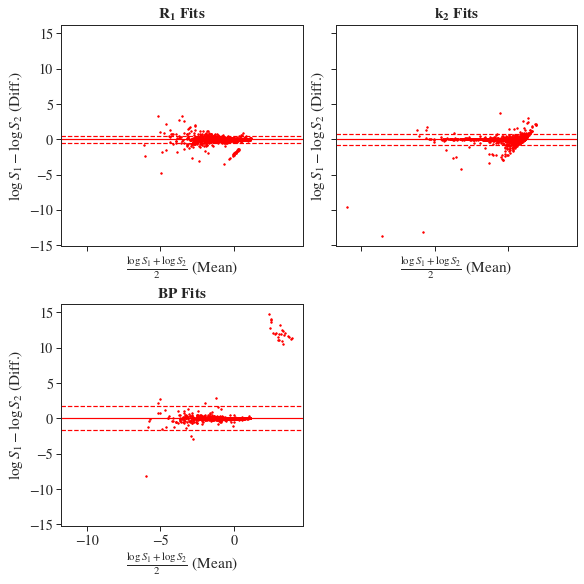

In [15]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8],
                           constrained_layout=True, sharex=True, sharey=True)
ratio_bland_atlman_figure(axes=myAx,
                          fit_values=srtm_fits_unbounded,
                          true_values=srtm_test_params_large,
                          ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

### Bounded Fits

#### Generating Random Samples

In [35]:
srtm_fits_bounded, srtm_fit_covs_bounded = calculate_bounded_rtm_fits_from_multiple_parameter_samples(
    ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=srtm_test_params_large,
    model_func=pet_rtms.calc_srtm_tac, fit_func=pet_rtms.fit_srtm_to_tac_with_bounds, noise_scale=0.01, start=0.5,
    hi=4.0, lo=0.0)

#### Scatter Plot

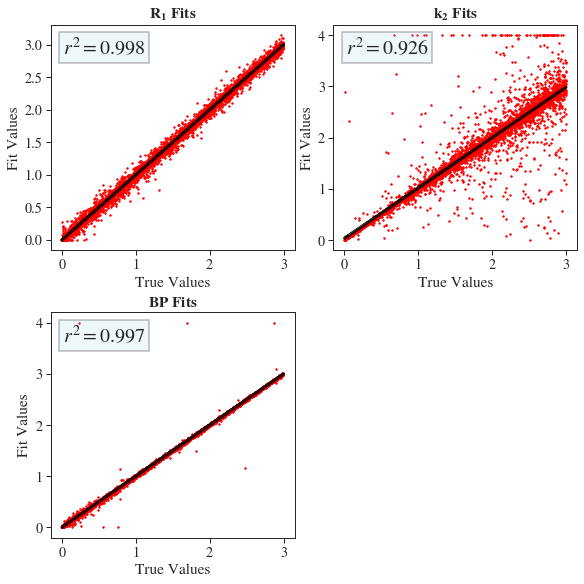

In [36]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
scatter_with_regression_figure(axes=myAx,
                               fit_values=srtm_fits_bounded,
                               true_values=srtm_test_params_large,
                               ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
# myFig.suptitle("Bounded Fits For SRTM Fit $R_1$ And $\mathrm{BP}$ Better Than $k_2$", color='darkgreen')
plt.show()

#### Bland-Altman Plot

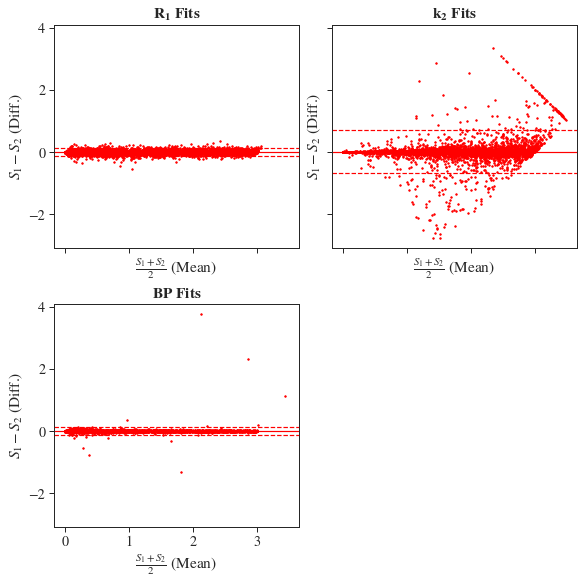

In [37]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True, 
                           sharex=True, sharey=True)
bland_atlman_figure(axes=myAx,
                    fit_values=srtm_fits_bounded,
                    true_values=srtm_test_params_large,
                    ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

#### Ratio Bland Altman Plot

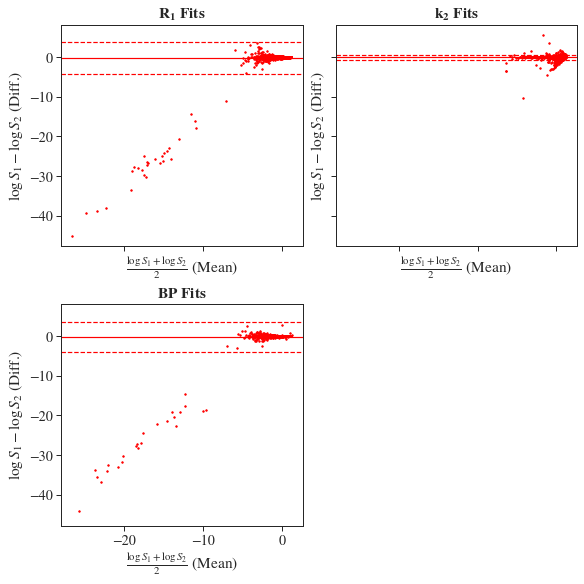

In [38]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True,
                           sharex=True, sharey=True)
ratio_bland_atlman_figure(axes=myAx,
                          fit_values=srtm_fits_bounded,
                          true_values=srtm_test_params_large,
                          ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', r'$\mathbf{BP}$'])
myAx[-1, -1].axis('off')
plt.show()

# Full Reference Tissue Model (FRTM)

Given, $R_{1}\equiv \frac{k_{1}^{\prime}}{k_{1}^{\prime}}$, the analytical solution for the FRTM, as a function of some reference region TAC, $C_\mathrm{R}(t)$, can be written as:
$$
C(t) = R_{1}C_\mathrm{R}(t) + \left[ A_{1}e^{-\alpha_{1}t} + A_{2}e^{-\alpha_{2}t} \right] \otimes C_\mathrm{R}(t),
$$
where the $\alpha_1$, $\alpha_2$, $A_1$, and $A_2$ depend on the underlying kinetic constants $k_2$, $k_3$, $k_4$, along with the predefined $R_1$, as:
$$
\begin{align}
\alpha_{1} &= \frac{k_{2} + k_{3} + k_{4} - \sqrt{\left( k_{2} + k_{3} + k_{4} \right)^2 - 4k_{2}k_{4}}}{2}\\
\alpha_{2} &= \frac{k_{2} + k_{3} + k_{4} + \sqrt{\left( k_{2} + k_{3} + k_{4} \right)^2 - 4k_{2}k_{4}}}{2}\\
A_{1} &= \left( \frac{k_{3} + k_{4} -\alpha_{2}}{\alpha_{1} - \alpha_{2}} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{2} \right)\\
A_{2} &= \left(  \frac{\alpha_{1}-k_{3} - k_{4} }{\alpha_{1} - \alpha_{2}} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{1} \right)
\end{align}
$$
Here, we can define $\beta\equiv k_{2} + k_{3} +k_{4}$, and $\chi\equiv\sqrt{\beta^2 - 4k_{2}k_{4}}$ to make the $\alpha$'s more compact:
$$
\begin{align}
\alpha_{1} &= \frac{\beta - \chi}{2}\\
\alpha_{2} &= \frac{\beta + \chi}{2}\\
A_{1} &= \left(\frac{k_{3} + k_{4} -\alpha_{2}}{\chi} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{2} \right)\\
A_{2} &= \left(\frac{\alpha_{1}-k_{3} - k_{4} }{\chi} \right)\left( \frac{k_{2}}{R_{1}} - \alpha_{1} \right)
\end{align}
$$


## Generating An Example Reference Region
We use a 1TCM with $K_1=1.0$ and $k_2=0.1$.

In [39]:
ref_tac_times, ref_tac_vals = pet_tcm.generate_tac_1tcm_c1_from_tac(tac_times=input_tac_times, 
                                                                    tac_vals=input_tac_vals,
                                                                    k1=1.0, k2=0.1)

### Example FRTM TAC
We use $R_1=0.5$, $k_2=0.01$, $k_3=0.3$ and $k_4=0.01$.

In [40]:
frtm_test_params = np.asarray((0.5, 0.01, 0.3, 0.01))
frtm_tac_vals = pet_rtms.calc_frtm_tac(tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, r1=0.5, k2=0.01, k3=0.3,
                                       k4=0.01)


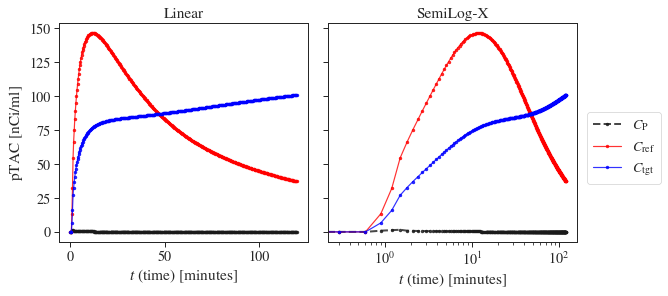

In [41]:
myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(input_tac_times, input_tac_vals / 50., '.--', alpha=0.8, color='k', label=r'$C_\mathrm{P}$', lw=2)
    anAx.plot(ref_tac_times, ref_tac_vals, '.-', alpha=0.8, color='red', label=r'$C_\mathrm{ref}$')
    anAx.plot(ref_tac_times, frtm_tac_vals, '.-', alpha=0.8, color='blue', label=r'$C_\mathrm{tgt}$')
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Simple Visual Inspection Of Fits

### Generating Ramdom Samples For The Parameters

In [42]:
frtm_test_params = generate_random_parameter_samples(num_samples=5, num_params=4, hi=5.0, lo=0.001)
frtm_test_params

array([[3.70160677, 4.2868696 , 1.12652816, 2.95581232],
       [3.66550278, 2.36508721, 4.16409591, 2.54485035],
       [1.58702493, 2.61820773, 0.16700367, 2.58086296],
       [1.48160583, 2.05751687, 0.82421019, 2.66642477],
       [1.78220709, 4.99357583, 4.07788092, 2.46089145]])

### Plotting Data And Fits Together

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (3.70 , 4.29 , 1.13 , 2.96 ); 
pOpt:    (3.41 , 6.00 , 0.02 , 2.78 ); (-0.29, 1.71 , -1.11, -0.17); (-7.96, 39.96, -98.61, -5.87); 


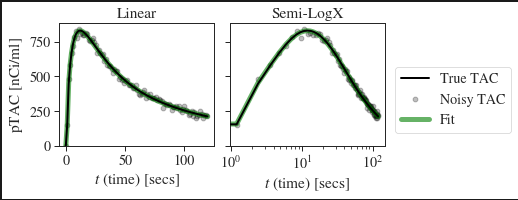

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (3.67 , 2.37 , 4.16 , 2.54 ); 
pOpt:    (3.73 , 2.05 , 6.00 , 3.29 ); (0.06 , -0.31, 1.84 , 0.74 ); (1.66 , -13.28, 44.09, 29.17); 


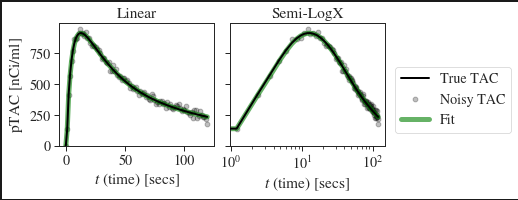

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (1.59 , 2.62 , 0.17 , 2.58 ); 
pOpt:    (1.36 , 6.00 , 1.88 , 6.00 ); (-0.23, 3.38 , 1.72 , 3.42 ); (-14.39, 129.16, 1028.33, 132.48); 


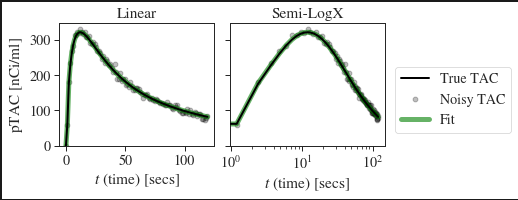

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (1.48 , 2.06 , 0.82 , 2.67 ); 
pOpt:    (1.58 , 1.36 , 1.84 , 4.72 ); (0.10 , -0.70, 1.02 , 2.05 ); (6.63 , -34.05, 123.26, 76.91); 


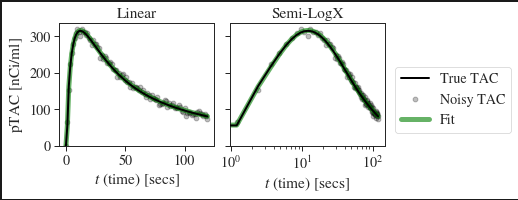

--------------------------------------------------------------------------------
Value                                ;Diff                         ;%Diff                           
Actual:  (1.78 , 4.99 , 4.08 , 2.46 ); 
pOpt:    (1.89 , 4.96 , 1.72 , 1.70 ); (0.11 , -0.03, -2.36, -0.76); (6.17 , -0.69, -57.86, -30.95); 


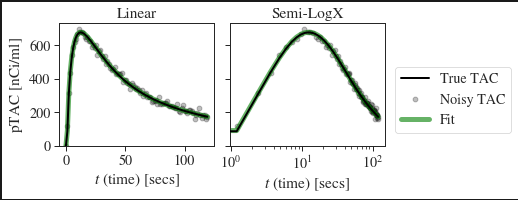

In [44]:
stride = 4  # To reduce the number of shown points for clarity
model_func = pet_rtms.calc_frtm_tac
for tID, t_params in enumerate(frtm_test_params[:]):
    rtm_tac_vals = model_func(ref_tac_times, ref_tac_vals, *t_params)
    if np.min(rtm_tac_vals) < 0:
        continue
    print('-' * 80)
    print(f"{'Value':<37};{'Diff':<29};{'%Diff':<32}")
    
    noisy_tgt_vals = add_gaussian_noise_to_tac_based_on_max(rtm_tac_vals, scale=0.02)
    
    pOpt, pCor = pet_rtms.fit_frtm_to_tac_with_bounds(tgt_tac_vals=noisy_tgt_vals, tac_times=ref_tac_times,
                                                      ref_tac_vals=ref_tac_vals, r1_bounds=(1.0, 0.0001, 6.0),
                                                      k2_bounds=(1.0, 0.0001, 6.0), k3_bounds=(1.0, 0.0001, 6.0),
                                                      k4_bounds=(1.0, 0.0001, 6.0))
    print_arrs("Actual", t_params)
    print_arrs("pOpt", *calc_diff(t_params, pOpt))
    
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8 / 1.5, 4 / 1.5], sharey=True, linewidth=3.0,
                               edgecolor='k')
    for anAx in myAx.flatten():
        anAx.plot(ref_tac_times[::stride], rtm_tac_vals[::stride], '-', alpha=1.0, color='black', label=r'True TAC',
                  lw=2.0, zorder=4)
        anAx.plot(ref_tac_times[::stride], noisy_tgt_vals[::stride], 'o', alpha=0.25, color='black', label=r'Noisy TAC')
        yAr = model_func(ref_tac_times, ref_tac_vals, *pOpt)
        anAx.plot(ref_tac_times[::stride], yAr[::stride], '-', alpha=0.6, color='green', lw=5, label='Fit')
    
    leg_hands, leg_labs = list(myAx[0].get_legend_handles_labels())
    
    myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear', ylim=(-0.25, None), xlabel='$t$ (time) [secs]')
    myAx[1].set(xscale='log', ylim=(-0.0001, None), title='Semi-LogX', xlabel='$t$ (time) [secs]')
    
    myFig.legend(leg_hands, leg_labs, bbox_to_anchor=(1.0, 0.5), loc='center left')
    plt.show()


## Generating A Simple Scatter Plot Of Fits vs. Real Values From Many Random Values

### Unbounded Fits

#### Generating Random Samples

In [45]:
frtm_test_params_large = generate_random_parameter_samples(num_samples=100, num_params=4, hi=3.0, lo=0.01)

In [46]:
num_samples = 5000

frtm_test_params_large = generate_random_parameter_samples(num_samples=num_samples, num_params=4, hi=3.0, lo=0.001)
frtm_fits_unbounded, frtm_fit_covs_unbounded = calculate_rtm_fits_from_multiple_parameter_samples(
    ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=frtm_test_params_large,
    model_func=pet_rtms.calc_frtm_tac, fit_func=pet_rtms.fit_frtm_to_tac, noise_scale=0.01)

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/kinetic_modeling/reference_tissue_models.py:160: RuntimeWarning:

invalid value encountered in sqrt

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/kinetic_modeling/reference_tissue_models.py:114: RuntimeWarning:

overflow encountered in exp

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/kinetic_modeling/reference_tissue_models.py:114: RuntimeWarning:

invalid value encountered in add

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/kinetic_modeling/reference_tissue_models.py:114: RuntimeWarning:

overflow encountered in multiply

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/kinetic_modeling/reference_tissue_models.py:452: OptimizeWarning:

Covariance of the parameters could not be estimated



#### Scatter Plot

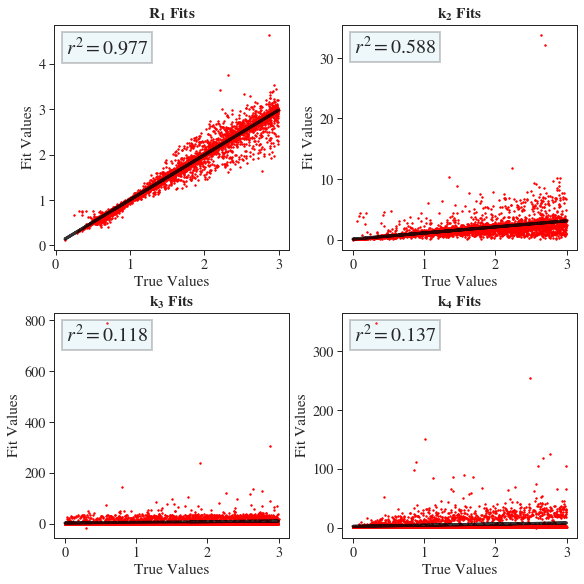

In [47]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
scatter_with_regression_figure(axes=myAx, fit_values=frtm_fits_unbounded,
                               true_values=frtm_test_params_large,
                               ax_titles=[r'$\mathbf{R_1}$', 
                                          r'$\mathbf{k_2}$', 
                                          r'$\mathbf{k_3}$',
                                          r'$\mathbf{k_4}$'])
# myFig.suptitle("Unbounded Fits For SRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

#### Bland-Altman Plot

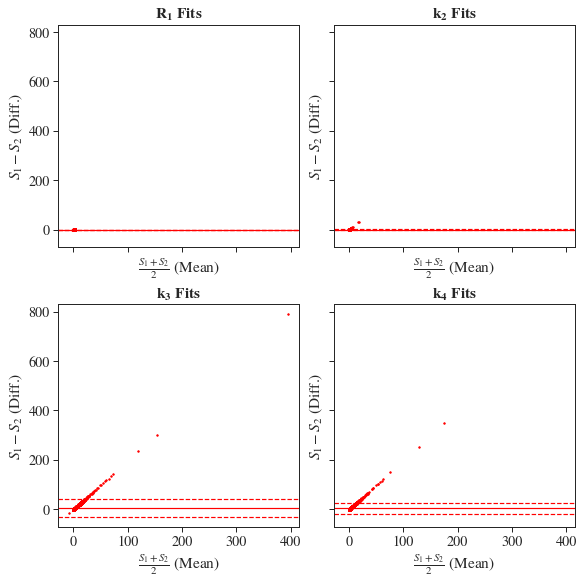

In [48]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True,
                           sharex=True, sharey=True)
bland_atlman_figure(axes=myAx,
                    fit_values=frtm_fits_unbounded,
                    true_values=frtm_test_params_large,
                    ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$', 
                               r'$\mathbf{k_3}$', r'$\mathbf{k_4}$'])
plt.show()

#### Ratio Bland Altman Plot

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/utils/testing_utils.py:270: RuntimeWarning:

invalid value encountered in log

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/utils/testing_utils.py:271: RuntimeWarning:

invalid value encountered in log



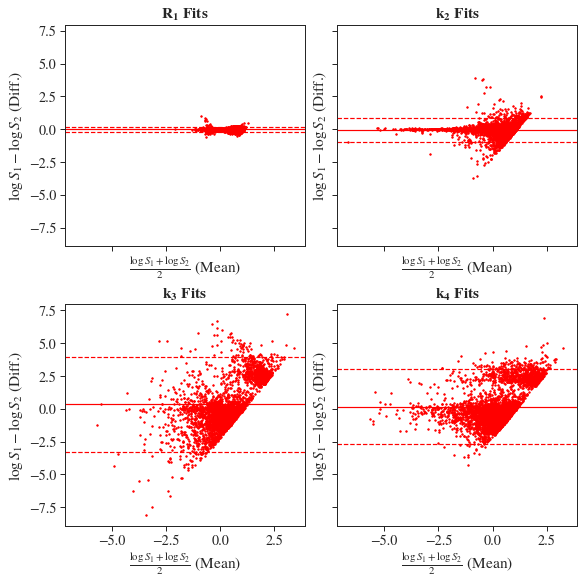

In [49]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True,
                           sharex=True, sharey=True)
ratio_bland_atlman_figure(axes=myAx,
                          fit_values=frtm_fits_unbounded,
                          true_values=frtm_test_params_large,
                          ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$',
                                     r'$\mathbf{k_3}$', r'$\mathbf{k_4}$'])
plt.show()

### Bounded Fits

#### Fitting The Random Samples

In [50]:
frtm_fits_bounded, frtm_fit_covs_bounded = calculate_bounded_rtm_fits_from_multiple_parameter_samples(
        ref_tac_times=ref_tac_times, ref_tac_vals=ref_tac_vals, param_samples=frtm_test_params_large,
        model_func=pet_rtms.calc_frtm_tac, fit_func=pet_rtms.fit_frtm_to_tac_with_bounds, noise_scale=0.01, start=0.5,
        hi=5.0, lo=0.0)

#### Scatter Plot

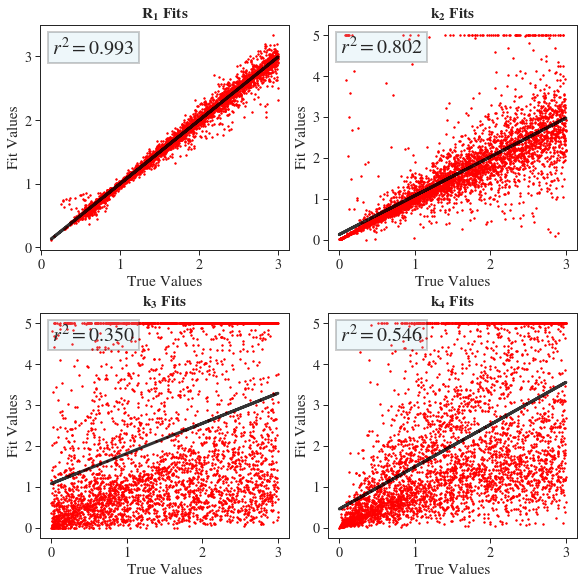

In [51]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True)
scatter_with_regression_figure(axes=myAx,
                               fit_values=frtm_fits_bounded,
                               true_values=frtm_test_params_large,
                               ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$',
                                          r'$\mathbf{k_3}$', r'$\mathbf{k_4}$'])
# myFig.suptitle("Unbounded Fits For SRTM Can Perform Very Poorly", color='darkgreen')
plt.show()

#### Bland-Altman Plot

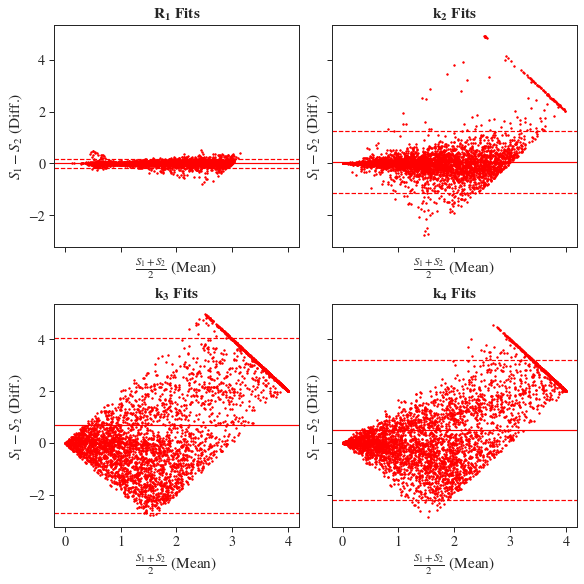

In [52]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True,
                           sharex=True, sharey=True)
bland_atlman_figure(axes=myAx,
                    fit_values=frtm_fits_bounded,
                    true_values=frtm_test_params_large,
                    ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$',
                               r'$\mathbf{k_3}$', r'$\mathbf{k_4}$'])
plt.show()

#### Ratio Bland Altman Plot

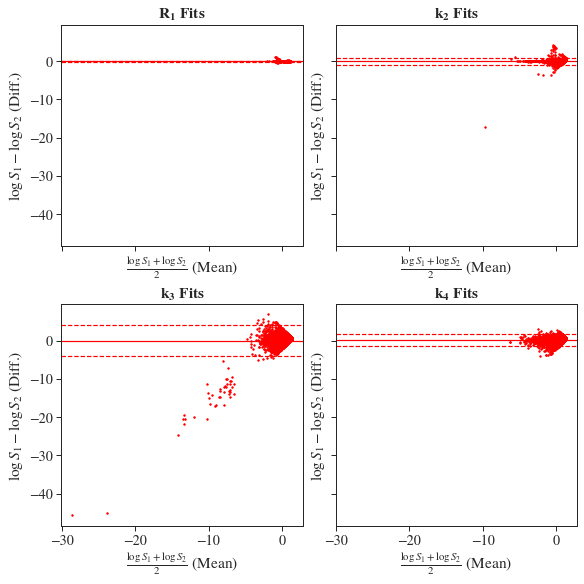

In [53]:
myFig, myAx = plt.subplots(2, 2, figsize=[8, 8], constrained_layout=True,
                           sharex=True, sharey=True)
ratio_bland_atlman_figure(axes=myAx,
                          fit_values=frtm_fits_bounded,
                          true_values=frtm_test_params_large,
                          ax_titles=[r'$\mathbf{R_1}$', r'$\mathbf{k_2}$',
                                     r'$\mathbf{k_3}$', r'$\mathbf{k_4}$'])
plt.show()